In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [5]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [6]:
X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [7]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [9]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=hp.Int('conv1',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv1size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=7),
                           strides=(2,2),padding='same')(inp)
        
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)

        #conv2
        c2 = Convolution2D(filters=hp.Int('conv2',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv2size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=5),
                           strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)
        
        #conv3
        c2 = Convolution2D(filters=hp.Int('conv3',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv3size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=3),
                           strides=(1,1),padding='same')(mpool)
        
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        #Conv 4
        c3 = Convolution2D(filters=hp.Int('conv4',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv4size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=3),
                           strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(512)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(256)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.3)(bt)

        x_dense = Dense(128)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(8, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [16]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(112,170,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat_conv_size'
)

INFO:tensorflow:Reloading Oracle from existing project random_search/bat_conv_size/oracle.json
INFO:tensorflow:Reloading Tuner from random_search/bat_conv_size/tuner0.json


In [18]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 5s - loss: 1.5338 - acc: 0.5189 - val_loss: 1.2606 - val_acc: 0.5785
Epoch 2/70
2172/2172 - 4s - loss: 1.3571 - acc: 0.5571 - val_loss: 1.3020 - val_acc: 0.5868
Epoch 3/70
2172/2172 - 4s - loss: 1.2557 - acc: 0.5948 - val_loss: 1.2061 - val_acc: 0.6364
Epoch 4/70
2172/2172 - 4s - loss: 1.2394 - acc: 0.5985 - val_loss: 1.2362 - val_acc: 0.5868
Epoch 5/70
2172/2172 - 4s - loss: 1.1529 - acc: 0.6022 - val_loss: 0.9874 - val_acc: 0.6198
Epoch 6/70
2172/2172 - 4s - loss: 1.0144 - acc: 0.6616 - val_loss: 1.3704 - val_acc: 0.6322
Epoch 7/70
2172/2172 - 4s - loss: 0.9495 - acc: 0.6796 - val_loss: 1.3878 - val_acc: 0.6364
Epoch 8/70
2172/2172 - 4s - loss: 0.8630 - acc: 0.7150 - val_loss: 0.7448 - val_acc: 0.7686
Epoch 9/70
2172/2172 - 4s - loss: 0.8075 - acc: 0.7376 - val_loss: 0.5423 - val_acc: 0.8017
Epoch 10/70
2172/2172 - 4s - loss: 0.7463 - acc: 0.7592 - val_loss: 0.4947 - val_acc: 0.8347
Epoch 11/70
2172/2172 - 4s - los

Epoch 19/70
2172/2172 - 4s - loss: 0.4328 - acc: 0.8679 - val_loss: 0.3206 - val_acc: 0.8884
Epoch 20/70
2172/2172 - 4s - loss: 0.3900 - acc: 0.8762 - val_loss: 0.2846 - val_acc: 0.9050
Epoch 21/70
2172/2172 - 4s - loss: 0.3995 - acc: 0.8679 - val_loss: 0.2327 - val_acc: 0.9091
Epoch 22/70
2172/2172 - 4s - loss: 0.3826 - acc: 0.8743 - val_loss: 0.3380 - val_acc: 0.9050
Epoch 23/70
2172/2172 - 3s - loss: 0.3893 - acc: 0.8803 - val_loss: 0.3076 - val_acc: 0.9215
Epoch 24/70
2172/2172 - 4s - loss: 0.3437 - acc: 0.8964 - val_loss: 0.2854 - val_acc: 0.9050
Epoch 25/70
2172/2172 - 4s - loss: 0.3134 - acc: 0.9006 - val_loss: 0.3947 - val_acc: 0.8719
Epoch 26/70
2172/2172 - 4s - loss: 0.3592 - acc: 0.8886 - val_loss: 0.2559 - val_acc: 0.9339
Epoch 27/70
2172/2172 - 4s - loss: 0.2852 - acc: 0.9070 - val_loss: 0.2331 - val_acc: 0.9298
Epoch 28/70
2172/2172 - 4s - loss: 0.3266 - acc: 0.9024 - val_loss: 0.2989 - val_acc: 0.9008
Epoch 29/70
2172/2172 - 4s - loss: 0.2716 - acc: 0.9125 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5257 - acc: 0.5203 - val_loss: 1.6349 - val_acc: 0.4917
Epoch 2/70
2172/2172 - 2s - loss: 1.3502 - acc: 0.5677 - val_loss: 1.1674 - val_acc: 0.6033
Epoch 3/70
2172/2172 - 3s - loss: 1.3252 - acc: 0.5612 - val_loss: 1.1398 - val_acc: 0.6157
Epoch 4/70
2172/2172 - 3s - loss: 1.2139 - acc: 0.6031 - val_loss: 1.1449 - val_acc: 0.6736
Epoch 5/70
2172/2172 - 3s - loss: 1.0892 - acc: 0.6367 - val_loss: 0.9449 - val_acc: 0.6860
Epoch 6/70
2172/2172 - 3s - loss: 0.9955 - acc: 0.6680 - val_loss: 0.8571 - val_acc: 0.7025
Epoch 7/70
2172/2172 - 3s - loss: 0.9076 - acc: 0.6994 - val_loss: 0.6895 - val_acc: 0.7479
Epoch 8/70
2172/2172 - 2s - loss: 0.8385 - acc: 0.7187 - val_loss: 0.6914 - val_acc: 0.7521
Epoch 9/70
2172/2172 - 2s - loss: 0.8047 - acc: 0.7357 - val_loss: 0.8873 - val_acc: 0.7231
Epoch 10/70
2172/2172 - 2s - loss: 0.7395 - acc: 0.7716 - val_loss: 0.5206 - val_acc: 0.8017
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4829 - acc: 0.8564 - val_loss: 0.2731 - val_acc: 0.9008
Epoch 20/70
2172/2172 - 2s - loss: 0.5056 - acc: 0.8536 - val_loss: 0.3048 - val_acc: 0.8802
Epoch 21/70
2172/2172 - 2s - loss: 0.4285 - acc: 0.8646 - val_loss: 0.3054 - val_acc: 0.8967
Epoch 22/70
2172/2172 - 2s - loss: 0.4133 - acc: 0.8665 - val_loss: 0.2746 - val_acc: 0.9132
Epoch 23/70
2172/2172 - 2s - loss: 0.4148 - acc: 0.8785 - val_loss: 0.2662 - val_acc: 0.9174
Epoch 24/70
2172/2172 - 2s - loss: 0.4262 - acc: 0.8633 - val_loss: 0.3423 - val_acc: 0.9050
Epoch 25/70
2172/2172 - 2s - loss: 0.4147 - acc: 0.8656 - val_loss: 0.3469 - val_acc: 0.9008
Epoch 26/70
2172/2172 - 2s - loss: 0.3608 - acc: 0.8895 - val_loss: 0.3253 - val_acc: 0.8967
Epoch 27/70
2172/2172 - 2s - loss: 0.3681 - acc: 0.8978 - val_loss: 0.2370 - val_acc: 0.9215
Epoch 28/70
2172/2172 - 2s - loss: 0.3309 - acc: 0.8959 - val_loss: 0.2518 - val_acc: 0.9339
Epoch 29/70
2172/2172 - 2s - loss: 0.3387 - acc: 0.8927 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5608 - acc: 0.4972 - val_loss: 1.4652 - val_acc: 0.5992
Epoch 2/70
2172/2172 - 2s - loss: 1.3631 - acc: 0.5594 - val_loss: 1.2793 - val_acc: 0.5537
Epoch 3/70
2172/2172 - 2s - loss: 1.3011 - acc: 0.5806 - val_loss: 1.1373 - val_acc: 0.6116
Epoch 4/70
2172/2172 - 2s - loss: 1.2728 - acc: 0.5838 - val_loss: 1.3651 - val_acc: 0.5950
Epoch 5/70
2172/2172 - 2s - loss: 1.1634 - acc: 0.6174 - val_loss: 1.0749 - val_acc: 0.6901
Epoch 6/70
2172/2172 - 2s - loss: 1.0448 - acc: 0.6487 - val_loss: 0.9343 - val_acc: 0.6983
Epoch 7/70
2172/2172 - 2s - loss: 0.9787 - acc: 0.6588 - val_loss: 0.7265 - val_acc: 0.7397
Epoch 8/70
2172/2172 - 2s - loss: 0.9266 - acc: 0.6911 - val_loss: 0.6801 - val_acc: 0.7727
Epoch 9/70
2172/2172 - 2s - loss: 0.8985 - acc: 0.7063 - val_loss: 0.6913 - val_acc: 0.7438
Epoch 10/70
2172/2172 - 2s - loss: 0.8341 - acc: 0.7109 - val_loss: 0.7904 - val_acc: 0.7645
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4449 - acc: 0.8605 - val_loss: 0.2556 - val_acc: 0.9091
Epoch 20/70
2172/2172 - 2s - loss: 0.4582 - acc: 0.8587 - val_loss: 0.2784 - val_acc: 0.8884
Epoch 21/70
2172/2172 - 2s - loss: 0.3716 - acc: 0.8895 - val_loss: 0.3506 - val_acc: 0.8884
Epoch 22/70
2172/2172 - 2s - loss: 0.4004 - acc: 0.8734 - val_loss: 0.2530 - val_acc: 0.9091
Epoch 23/70
2172/2172 - 2s - loss: 0.3365 - acc: 0.8900 - val_loss: 0.2594 - val_acc: 0.9091
Epoch 24/70
2172/2172 - 2s - loss: 0.3607 - acc: 0.8835 - val_loss: 0.2357 - val_acc: 0.9215
Epoch 25/70
2172/2172 - 2s - loss: 0.3188 - acc: 0.8950 - val_loss: 0.2243 - val_acc: 0.9256
Epoch 26/70
2172/2172 - 2s - loss: 0.3523 - acc: 0.8909 - val_loss: 0.2319 - val_acc: 0.9256
Epoch 27/70
2172/2172 - 2s - loss: 0.3245 - acc: 0.9001 - val_loss: 0.1972 - val_acc: 0.9380
Epoch 28/70
2172/2172 - 2s - loss: 0.3426 - acc: 0.8987 - val_loss: 0.2267 - val_acc: 0.9380
Epoch 29/70
2172/2172 - 2s - loss: 0.3008 - acc: 0.9033 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5195 - acc: 0.5087 - val_loss: 1.6224 - val_acc: 0.5207
Epoch 2/70
2172/2172 - 2s - loss: 1.3449 - acc: 0.5571 - val_loss: 1.4128 - val_acc: 0.5455
Epoch 3/70
2172/2172 - 2s - loss: 1.2788 - acc: 0.5778 - val_loss: 1.2371 - val_acc: 0.6529
Epoch 4/70
2172/2172 - 2s - loss: 1.2386 - acc: 0.5944 - val_loss: 1.4399 - val_acc: 0.6653
Epoch 5/70
2172/2172 - 2s - loss: 1.0994 - acc: 0.6266 - val_loss: 0.8656 - val_acc: 0.6653
Epoch 6/70
2172/2172 - 2s - loss: 0.9734 - acc: 0.6791 - val_loss: 1.1148 - val_acc: 0.6942
Epoch 7/70
2172/2172 - 2s - loss: 0.8494 - acc: 0.7145 - val_loss: 0.8541 - val_acc: 0.7149
Epoch 8/70
2172/2172 - 2s - loss: 0.7910 - acc: 0.7390 - val_loss: 0.7490 - val_acc: 0.7479
Epoch 9/70
2172/2172 - 2s - loss: 0.7315 - acc: 0.7606 - val_loss: 0.5366 - val_acc: 0.8058
Epoch 10/70
2172/2172 - 2s - loss: 0.6846 - acc: 0.7818 - val_loss: 0.4477 - val_acc: 0.8554
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.3996 - acc: 0.8775 - val_loss: 0.3857 - val_acc: 0.8595
Epoch 20/70
2172/2172 - 2s - loss: 0.3574 - acc: 0.8858 - val_loss: 0.2907 - val_acc: 0.9174
Epoch 21/70
2172/2172 - 3s - loss: 0.3349 - acc: 0.8923 - val_loss: 0.2578 - val_acc: 0.9132
Epoch 22/70
2172/2172 - 2s - loss: 0.3704 - acc: 0.8923 - val_loss: 0.2921 - val_acc: 0.9174
Epoch 23/70
2172/2172 - 2s - loss: 0.3274 - acc: 0.8996 - val_loss: 0.2868 - val_acc: 0.9050
Epoch 24/70
2172/2172 - 2s - loss: 0.2970 - acc: 0.9033 - val_loss: 0.2470 - val_acc: 0.9215
Epoch 25/70
2172/2172 - 2s - loss: 0.2845 - acc: 0.9001 - val_loss: 0.2036 - val_acc: 0.9050
Epoch 26/70
2172/2172 - 2s - loss: 0.3218 - acc: 0.8987 - val_loss: 0.2742 - val_acc: 0.8967
Epoch 27/70
2172/2172 - 2s - loss: 0.2798 - acc: 0.9185 - val_loss: 0.2607 - val_acc: 0.9298
Epoch 28/70
2172/2172 - 2s - loss: 0.2934 - acc: 0.9190 - val_loss: 0.2041 - val_acc: 0.9256
Epoch 29/70
2172/2172 - 2s - loss: 0.2651 - acc: 0.9199 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5316 - acc: 0.5115 - val_loss: 1.4004 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 2s - loss: 1.3482 - acc: 0.5658 - val_loss: 1.1497 - val_acc: 0.6364
Epoch 3/70
2172/2172 - 2s - loss: 1.2583 - acc: 0.5824 - val_loss: 1.0760 - val_acc: 0.6405
Epoch 4/70
2172/2172 - 2s - loss: 1.1526 - acc: 0.6183 - val_loss: 0.9539 - val_acc: 0.6983
Epoch 5/70
2172/2172 - 2s - loss: 1.0113 - acc: 0.6552 - val_loss: 0.7655 - val_acc: 0.7355
Epoch 6/70
2172/2172 - 2s - loss: 0.9623 - acc: 0.6952 - val_loss: 0.6950 - val_acc: 0.7603
Epoch 7/70
2172/2172 - 2s - loss: 0.9002 - acc: 0.6984 - val_loss: 0.7192 - val_acc: 0.7273
Epoch 8/70
2172/2172 - 2s - loss: 0.8479 - acc: 0.7187 - val_loss: 0.7739 - val_acc: 0.7149
Epoch 9/70
2172/2172 - 2s - loss: 0.8103 - acc: 0.7390 - val_loss: 0.5345 - val_acc: 0.8347
Epoch 10/70
2172/2172 - 2s - loss: 0.7675 - acc: 0.7546 - val_loss: 0.5743 - val_acc: 0.8182
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4464 - acc: 0.8550 - val_loss: 0.3931 - val_acc: 0.8843
Epoch 20/70
2172/2172 - 2s - loss: 0.4112 - acc: 0.8711 - val_loss: 0.2765 - val_acc: 0.9174
Epoch 21/70
2172/2172 - 2s - loss: 0.4189 - acc: 0.8720 - val_loss: 0.2822 - val_acc: 0.9091
Epoch 22/70
2172/2172 - 2s - loss: 0.4035 - acc: 0.8803 - val_loss: 0.2543 - val_acc: 0.9050
Epoch 23/70
2172/2172 - 2s - loss: 0.4393 - acc: 0.8605 - val_loss: 0.2885 - val_acc: 0.8802
Epoch 24/70
2172/2172 - 2s - loss: 0.3755 - acc: 0.8849 - val_loss: 0.2714 - val_acc: 0.9174
Epoch 25/70
2172/2172 - 2s - loss: 0.3764 - acc: 0.8840 - val_loss: 0.2412 - val_acc: 0.9174
Epoch 26/70
2172/2172 - 2s - loss: 0.3692 - acc: 0.8849 - val_loss: 0.2799 - val_acc: 0.9215
Epoch 27/70
2172/2172 - 2s - loss: 0.3473 - acc: 0.8950 - val_loss: 0.2321 - val_acc: 0.9050
Epoch 28/70
2172/2172 - 2s - loss: 0.3116 - acc: 0.9052 - val_loss: 0.2414 - val_acc: 0.9256
Epoch 29/70
2172/2172 - 2s - loss: 0.3438 - acc: 0.8909 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.5644 - acc: 0.5046 - val_loss: 1.8311 - val_acc: 0.4793
Epoch 2/70
2172/2172 - 3s - loss: 1.3807 - acc: 0.5506 - val_loss: 1.2369 - val_acc: 0.5868
Epoch 3/70
2172/2172 - 3s - loss: 1.2892 - acc: 0.5810 - val_loss: 1.3080 - val_acc: 0.6322
Epoch 4/70
2172/2172 - 3s - loss: 1.2357 - acc: 0.5962 - val_loss: 1.1103 - val_acc: 0.6074
Epoch 5/70
2172/2172 - 3s - loss: 1.0946 - acc: 0.6202 - val_loss: 1.1289 - val_acc: 0.6488
Epoch 6/70
2172/2172 - 3s - loss: 1.0062 - acc: 0.6685 - val_loss: 0.8628 - val_acc: 0.6860
Epoch 7/70
2172/2172 - 3s - loss: 0.9026 - acc: 0.6938 - val_loss: 1.5521 - val_acc: 0.5331
Epoch 8/70
2172/2172 - 3s - loss: 0.8286 - acc: 0.7261 - val_loss: 0.6989 - val_acc: 0.7355
Epoch 9/70
2172/2172 - 4s - loss: 0.7637 - acc: 0.7514 - val_loss: 0.5900 - val_acc: 0.7769
Epoch 10/70
2172/2172 - 3s - loss: 0.7352 - acc: 0.7629 - val_loss: 0.5919 - val_acc: 0.7975
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.4407 - acc: 0.8715 - val_loss: 0.2435 - val_acc: 0.9339
Epoch 20/70
2172/2172 - 3s - loss: 0.3866 - acc: 0.8812 - val_loss: 0.2902 - val_acc: 0.9008
Epoch 21/70
2172/2172 - 3s - loss: 0.3545 - acc: 0.8872 - val_loss: 0.3058 - val_acc: 0.9256
Epoch 22/70
2172/2172 - 3s - loss: 0.3779 - acc: 0.8725 - val_loss: 0.2357 - val_acc: 0.9215
Epoch 23/70
2172/2172 - 3s - loss: 0.3574 - acc: 0.8849 - val_loss: 0.4017 - val_acc: 0.9008
Epoch 24/70
2172/2172 - 3s - loss: 0.3572 - acc: 0.8872 - val_loss: 0.2068 - val_acc: 0.9421
Epoch 25/70
2172/2172 - 3s - loss: 0.3206 - acc: 0.9038 - val_loss: 0.2468 - val_acc: 0.9215
Epoch 26/70
2172/2172 - 3s - loss: 0.3203 - acc: 0.8918 - val_loss: 0.2244 - val_acc: 0.9380
Epoch 27/70
2172/2172 - 3s - loss: 0.2888 - acc: 0.9019 - val_loss: 0.2853 - val_acc: 0.9215
Epoch 28/70
2172/2172 - 3s - loss: 0.2981 - acc: 0.9042 - val_loss: 0.1886 - val_acc: 0.9380
Epoch 29/70
2172/2172 - 3s - loss: 0.2630 - acc: 0.9167 - val_loss: 0.

INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

In [20]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

604/604 [==============================] - ETA: 2s - loss: 0.0121 - acc: 1.000 - ETA: 0s - loss: 0.1611 - acc: 0.954 - ETA: 0s - loss: 0.1141 - acc: 0.966 - 0s 502us/sample - loss: 0.1053 - acc: 0.9669


In [21]:
accuracy

0.9668874

<h2>Evaluate Best Model</h2>

In [22]:
model = best_model

[[  5   0   0   0   0   0   0   0]
 [  0  25   0   0   0   0   0   0]
 [  0   1  16   1   1   0   1   2]
 [  0   0   0  58   0   0   1   1]
 [  0   0   1   0 329   0   2   1]
 [  0   0   1   1   0  52   0   0]
 [  0   0   0   0   1   0  23   0]
 [  0   0   0   0   4   0   1  76]]


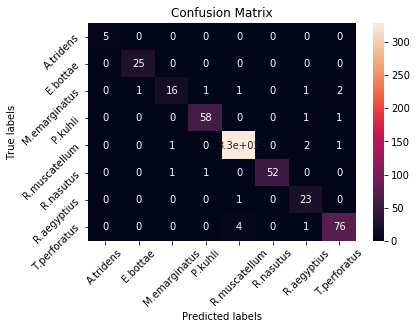

In [23]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [24]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9668874172185431


In [25]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

               precision    recall  f1-score   support

    A.tridens       1.00      1.00      1.00         5
     E.bottae       0.96      1.00      0.98        25
M.emarginatus       0.89      0.73      0.80        22
      P.kuhli       0.97      0.97      0.97        60
R.muscatellum       0.98      0.99      0.99       333
    R.nasutus       1.00      0.96      0.98        54
  R.aegyptius       0.82      0.96      0.88        24
 T.perforatus       0.95      0.94      0.94        81

     accuracy                           0.97       604
    macro avg       0.95      0.94      0.94       604
 weighted avg       0.97      0.97      0.97       604



<h2>K-Fold Training and Evaluation</h2>

In [8]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=120,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=248,kernel_size=(5,5),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 120)       9120      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 120)       480       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 120)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 120)       0         
_________

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 - 4s - loss: 1.4938 - acc: 0.5249 - val_loss: 1.4756 - val_acc: 0.4959
Epoch 2/100
2172/2172 - 3s - loss: 1.3303 - acc: 0.5750 - val_loss: 1.8179 - val_acc: 0.3802
Epoch 3/100
2172/2172 - 3s - loss: 1.2542 - acc: 0.5935 - val_loss: 1.1950 - val_acc: 0.6405
Epoch 4/100
2172/2172 - 3s - loss: 1.0753 - acc: 0.6441 - val_loss: 1.1545 - val_acc: 0.6364
Epoch 5/100
2172/2172 - 3s - loss: 0.9717 - acc: 0.6759 - val_loss: 1.0876 - val_acc: 0.6653
Epoch 6/100
2172/2172 - 3s - loss: 0.9055 - acc: 0.7021 - val_loss: 0.9062 - val_acc: 0.7107
Epoch 7/100
2172/2172 - 3s - loss: 0.8264 - acc: 0.7251 - val_loss: 0.8075 - val_acc: 0.7066
Epoch 8/100
2172/2172 - 3s - loss: 0.8094 - acc: 0.7366 - val_loss: 0.7217 - val_acc: 0.7314
Epoch 9/100
2172/2172 - 3s - loss: 0.7266 - acc: 0.7689 - val_loss: 0.6633 - val_acc: 0.7645
Epoch 10/100
2172/2172 - 3s - loss: 0.7051 - acc: 0.7703 - val_loss: 0.4322 - val_acc: 0.8471
Epoch 11/100
2172/2172

Epoch 88/100
2172/2172 - 3s - loss: 0.0628 - acc: 0.9784 - val_loss: 0.2051 - val_acc: 0.9545
Epoch 89/100
2172/2172 - 3s - loss: 0.0708 - acc: 0.9830 - val_loss: 0.1727 - val_acc: 0.9711
Epoch 90/100
2172/2172 - 3s - loss: 0.0996 - acc: 0.9687 - val_loss: 0.1690 - val_acc: 0.9587
Epoch 91/100
2172/2172 - 3s - loss: 0.0636 - acc: 0.9797 - val_loss: 0.1381 - val_acc: 0.9752
Epoch 92/100
2172/2172 - 3s - loss: 0.0831 - acc: 0.9765 - val_loss: 0.1188 - val_acc: 0.9752
Epoch 93/100
2172/2172 - 3s - loss: 0.0548 - acc: 0.9839 - val_loss: 0.1362 - val_acc: 0.9752
Epoch 94/100
2172/2172 - 3s - loss: 0.0727 - acc: 0.9779 - val_loss: 0.1728 - val_acc: 0.9711
Epoch 95/100
2172/2172 - 3s - loss: 0.1070 - acc: 0.9756 - val_loss: 0.1690 - val_acc: 0.9628
Epoch 96/100
2172/2172 - 3s - loss: 0.0801 - acc: 0.9784 - val_loss: 0.2335 - val_acc: 0.9545
Epoch 97/100
2172/2172 - 3s - loss: 0.0698 - acc: 0.9793 - val_loss: 0.1595 - val_acc: 0.9711
Epoch 98/100
2172/2172 - 3s - loss: 0.0478 - acc: 0.9862 - v

Epoch 75/100
2172/2172 - 3s - loss: 0.1079 - acc: 0.9701 - val_loss: 0.1947 - val_acc: 0.9421
Epoch 76/100
2172/2172 - 3s - loss: 0.1040 - acc: 0.9682 - val_loss: 0.1322 - val_acc: 0.9545
Epoch 77/100
2172/2172 - 3s - loss: 0.1082 - acc: 0.9751 - val_loss: 0.1152 - val_acc: 0.9669
Epoch 78/100
2172/2172 - 3s - loss: 0.0725 - acc: 0.9784 - val_loss: 0.0855 - val_acc: 0.9669
Epoch 79/100
2172/2172 - 3s - loss: 0.0796 - acc: 0.9761 - val_loss: 0.1445 - val_acc: 0.9711
Epoch 80/100
2172/2172 - 3s - loss: 0.0671 - acc: 0.9816 - val_loss: 0.0906 - val_acc: 0.9711
Epoch 81/100
2172/2172 - 3s - loss: 0.0968 - acc: 0.9738 - val_loss: 0.1052 - val_acc: 0.9752
Epoch 82/100
2172/2172 - 3s - loss: 0.0863 - acc: 0.9761 - val_loss: 0.1898 - val_acc: 0.9380
Epoch 83/100
2172/2172 - 3s - loss: 0.0965 - acc: 0.9756 - val_loss: 0.2757 - val_acc: 0.9380
Epoch 84/100
2172/2172 - 3s - loss: 0.0598 - acc: 0.9820 - val_loss: 0.2308 - val_acc: 0.9545
Epoch 85/100
2172/2172 - 3s - loss: 0.0753 - acc: 0.9784 - v

Epoch 62/100
2172/2172 - 3s - loss: 0.1270 - acc: 0.9669 - val_loss: 0.1604 - val_acc: 0.9628
Epoch 63/100
2172/2172 - 3s - loss: 0.1188 - acc: 0.9673 - val_loss: 0.1535 - val_acc: 0.9587
Epoch 64/100
2172/2172 - 3s - loss: 0.1070 - acc: 0.9692 - val_loss: 0.1205 - val_acc: 0.9669
Epoch 65/100
2172/2172 - 3s - loss: 0.1089 - acc: 0.9696 - val_loss: 0.1893 - val_acc: 0.9463
Epoch 66/100
2172/2172 - 3s - loss: 0.1322 - acc: 0.9586 - val_loss: 0.0957 - val_acc: 0.9711
Epoch 67/100
2172/2172 - 3s - loss: 0.1054 - acc: 0.9618 - val_loss: 0.1589 - val_acc: 0.9504
Epoch 68/100
2172/2172 - 3s - loss: 0.1334 - acc: 0.9609 - val_loss: 0.2827 - val_acc: 0.9256
Epoch 69/100
2172/2172 - 3s - loss: 0.1495 - acc: 0.9604 - val_loss: 0.0935 - val_acc: 0.9752
Epoch 70/100
2172/2172 - 3s - loss: 0.0907 - acc: 0.9724 - val_loss: 0.1121 - val_acc: 0.9752
Epoch 71/100
2172/2172 - 3s - loss: 0.0887 - acc: 0.9687 - val_loss: 0.1590 - val_acc: 0.9669
Epoch 72/100
2172/2172 - 3s - loss: 0.0872 - acc: 0.9765 - v

Epoch 49/100
2173/2173 - 3s - loss: 0.1650 - acc: 0.9471 - val_loss: 0.1617 - val_acc: 0.9421
Epoch 50/100
2173/2173 - 3s - loss: 0.2027 - acc: 0.9397 - val_loss: 0.1934 - val_acc: 0.9339
Epoch 51/100
2173/2173 - 3s - loss: 0.1890 - acc: 0.9434 - val_loss: 0.1070 - val_acc: 0.9669
Epoch 52/100
2173/2173 - 3s - loss: 0.1347 - acc: 0.9572 - val_loss: 0.0933 - val_acc: 0.9587
Epoch 53/100
2173/2173 - 3s - loss: 0.1811 - acc: 0.9485 - val_loss: 0.2647 - val_acc: 0.9298
Epoch 54/100
2173/2173 - 3s - loss: 0.1472 - acc: 0.9521 - val_loss: 0.1421 - val_acc: 0.9463
Epoch 55/100
2173/2173 - 3s - loss: 0.1699 - acc: 0.9388 - val_loss: 0.0846 - val_acc: 0.9752
Epoch 56/100
2173/2173 - 3s - loss: 0.1652 - acc: 0.9512 - val_loss: 0.1617 - val_acc: 0.9504
Epoch 57/100
2173/2173 - 3s - loss: 0.1493 - acc: 0.9563 - val_loss: 0.1236 - val_acc: 0.9587
Epoch 58/100
2173/2173 - 3s - loss: 0.1216 - acc: 0.9586 - val_loss: 0.1365 - val_acc: 0.9628
Epoch 59/100
2173/2173 - 3s - loss: 0.1741 - acc: 0.9498 - v

Epoch 36/100
2173/2173 - 3s - loss: 0.2422 - acc: 0.9231 - val_loss: 0.2670 - val_acc: 0.9132
Epoch 37/100
2173/2173 - 3s - loss: 0.2551 - acc: 0.9268 - val_loss: 0.5384 - val_acc: 0.8182
Epoch 38/100
2173/2173 - 3s - loss: 0.2230 - acc: 0.9268 - val_loss: 0.2506 - val_acc: 0.9091
Epoch 39/100
2173/2173 - 3s - loss: 0.2046 - acc: 0.9406 - val_loss: 0.1663 - val_acc: 0.9421
Epoch 40/100
2173/2173 - 3s - loss: 0.2074 - acc: 0.9360 - val_loss: 0.3168 - val_acc: 0.9050
Epoch 41/100
2173/2173 - 3s - loss: 0.2271 - acc: 0.9268 - val_loss: 0.2247 - val_acc: 0.9256
Epoch 42/100
2173/2173 - 3s - loss: 0.1705 - acc: 0.9457 - val_loss: 0.1555 - val_acc: 0.9463
Epoch 43/100
2173/2173 - 3s - loss: 0.1563 - acc: 0.9489 - val_loss: 0.2344 - val_acc: 0.9050
Epoch 44/100
2173/2173 - 3s - loss: 0.1925 - acc: 0.9420 - val_loss: 0.1730 - val_acc: 0.9298
Epoch 45/100
2173/2173 - 3s - loss: 0.1987 - acc: 0.9383 - val_loss: 0.1994 - val_acc: 0.9132
Epoch 46/100
2173/2173 - 3s - loss: 0.2157 - acc: 0.9402 - v

In [11]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.96666667 0.94729345 0.82610041 0.96276047 0.97973421 0.97820096
 0.8873374  0.96489756]
precision sdev by class [0.06666667 0.06537825 0.1131975  0.02480002 0.01016871 0.0205738
 0.06674426 0.00829494]
macro precision mean 0.9391238909303417
macro precision sdev 0.01635585139028059
recall mean [0.92       0.93566667 0.86679842 0.94661017 0.98138138 0.96268344
 0.93466667 0.94787037]
recall sdev [0.09797959 0.01919491 0.06155865 0.02860231 0.0044135  0.02658739
 0.05417461 0.02418351]
macro recall mean 0.9369596389630098
macro recall sdev 0.01351125386806832
f1 mean [0.93737374 0.94064495 0.83983155 0.95447725 0.98051975 0.9698934
 0.90877287 0.95605381]
f1 sdev [0.05166348 0.03978815 0.0590863  0.02410407 0.00500875 0.00984632
 0.04625488 0.00955325]
macro f1 mean 0.935945914908954
macro f1 sdev 0.014240692211913432
accuracy mean 0.9632214204913622
accuracy sdev 0.003027278753578768


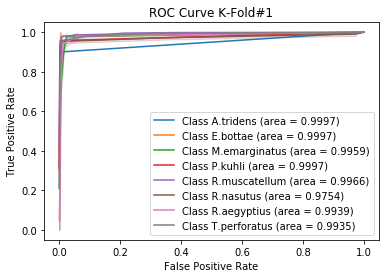

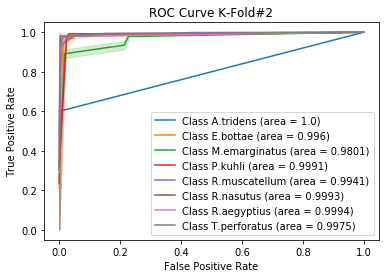

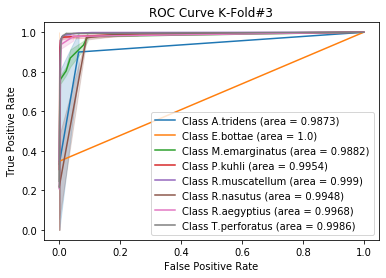

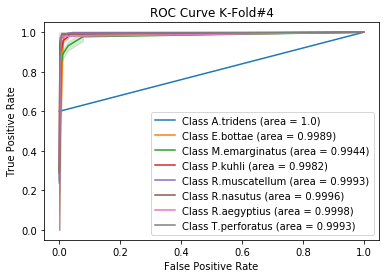

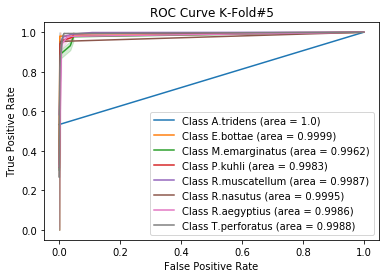

In [12]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

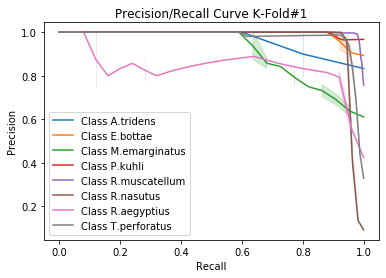

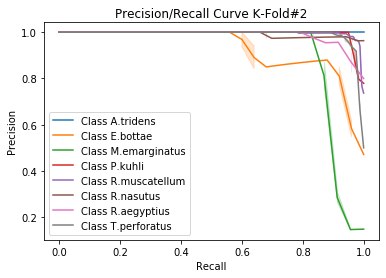

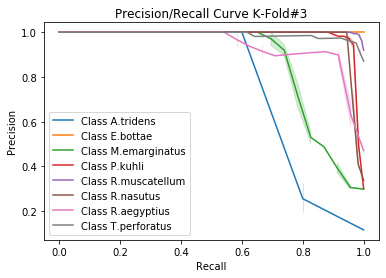

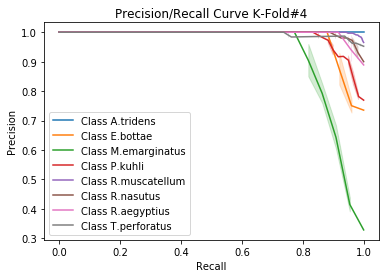

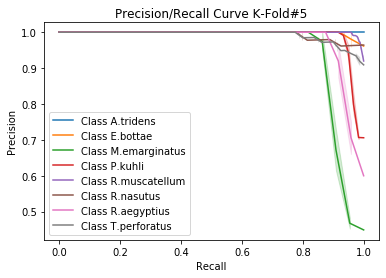

In [13]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  4   0   0   0   0   0   1   0]
 [  0  23   1   0   0   0   1   0]
 [  0   0  21   0   0   0   1   0]
 [  0   0   0  58   1   0   0   0]
 [  0   0   5   0 326   0   0   2]
 [  0   0   0   1   0  51   1   1]
 [  0   0   3   1   0   0  21   0]
 [  0   0   1   0   3   0   1  76]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  23   0   0   1   1   0   0]
 [  0   0  20   0   3   0   0   0]
 [  0   0   0  58   1   0   0   1]
 [  0   4   0   0 326   0   2   1]
 [  0   0   0   2   2  49   0   0]
 [  0   0   0   0   1   0  23   0]
 [  0   0   1   0   4   0   0  76]]


Confusion Matrix K-Fold #3

[[  4   0   0   0   0   0   1   0]
 [  0  23   0   0   1   0   0   0]
 [  0   0  18   0   1   0   1   3]
 [  0   0   1  57   1   0   1   0]
 [  0   0   3   1 328   0   0   1]
 [  0   0   1   0   0  52   1   0]
 [  0   0   1   0   0   0  23   0]
 [  0   0   1   0   1   0   0  79]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

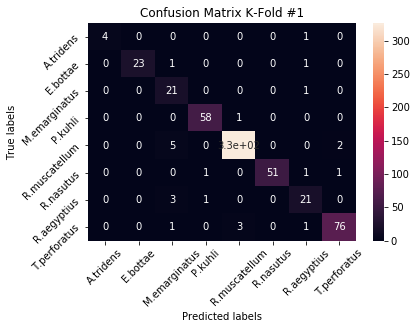

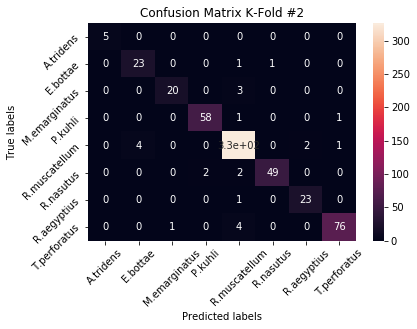

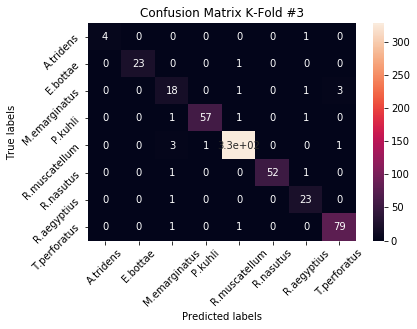

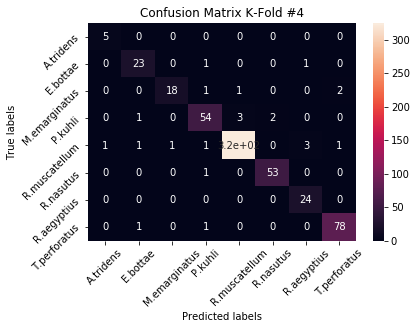

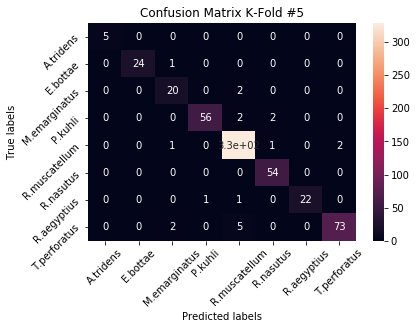

In [14]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  116    2    1    2    1    2    0]
 [   0    0   97    1    7    0    2    5]
 [   0    1    1  283    8    4    1    1]
 [   1    5   10    2 1634    1    5    7]
 [   0    0    1    4    2  259    2    1]
 [   0    0    4    2    2    0  113    0]
 [   0    1    5    1   13    0    1  382]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  23   0   0   0   0   0   0]
 [  0   0  19   0   1   0   0   1]
 [  0   0   0  56   1   0   0   0]
 [  0   1   2   0 326   0   1   1]
 [  0   0   0   0   0  51   0   0]
 [  0   0   0   0   0   0  22   0]
 [  0   0   1   0   2   0   0  76]]


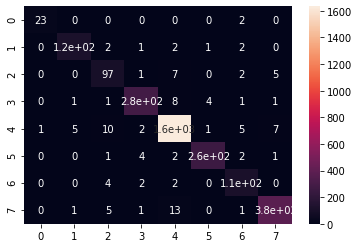

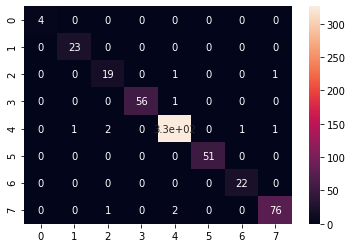

In [15]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.94 0.02 0.01 0.02 0.01 0.02 0.  ]
 [0.   0.   0.87 0.01 0.06 0.   0.02 0.04]
 [0.   0.   0.   0.95 0.03 0.01 0.   0.  ]
 [0.   0.   0.01 0.   0.98 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.01 0.96 0.01 0.  ]
 [0.   0.   0.03 0.02 0.02 0.   0.93 0.  ]
 [0.   0.   0.01 0.   0.03 0.   0.   0.95]]


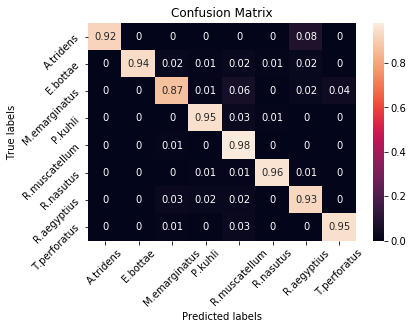

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Shuffled K-Fold Training and Evaluation</h2>

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 - 3s - loss: 1.4894 - acc: 0.5207 - val_loss: 1.4976 - val_acc: 0.5496
Epoch 2/100
2172/2172 - 3s - loss: 1.3297 - acc: 0.5700 - val_loss: 1.2189 - val_acc: 0.5826
Epoch 3/100
2172/2172 - 3s - loss: 1.2641 - acc: 0.5856 - val_loss: 1.1210 - val_acc: 0.5744
Epoch 4/100
2172/2172 - 3s - loss: 1.1942 - acc: 0.6054 - val_loss: 1.2707 - val_acc: 0.5702
Epoch 5/100
2172/2172 - 3s - loss: 1.0597 - acc: 0.6354 - val_loss: 1.0002 - val_acc: 0.6198
Epoch 6/100
2172/2172 - 3s - loss: 0.9768 - acc: 0.6680 - val_loss: 0.8346 - val_acc: 0.7397
Epoch 7/100
2172/2172 - 3s - loss: 0.9089 - acc: 0.6911 - val_loss: 0.7066 - val_acc: 0.7314
Epoch 8/100
2172/2172 - 3s - loss: 0.8385 - acc: 0.7159 - val_loss: 0.8603 - val_acc: 0.7438
Epoch 9/100
2172/2172 - 3s - loss: 0.8021 - acc: 0.7385 - val_loss: 0.7025 - val_acc: 0.7273
Epoch 10/100
2172/2172 - 3s - loss: 0.7083 - acc: 0.7574 - val_loss: 0.5293 - val_acc: 0.8099
Epoch 11/100
2172/2172

Epoch 88/100
2172/2172 - 3s - loss: 0.1214 - acc: 0.9673 - val_loss: 0.0876 - val_acc: 0.9711
Epoch 89/100
2172/2172 - 3s - loss: 0.0632 - acc: 0.9825 - val_loss: 0.0969 - val_acc: 0.9669
Epoch 90/100
2172/2172 - 3s - loss: 0.0744 - acc: 0.9784 - val_loss: 0.1232 - val_acc: 0.9587
Epoch 91/100
2172/2172 - 3s - loss: 0.0543 - acc: 0.9839 - val_loss: 0.1823 - val_acc: 0.9587
Epoch 92/100
2172/2172 - 3s - loss: 0.1021 - acc: 0.9738 - val_loss: 0.1698 - val_acc: 0.9545
Epoch 93/100
2172/2172 - 3s - loss: 0.0978 - acc: 0.9715 - val_loss: 0.0920 - val_acc: 0.9628
Epoch 94/100
2172/2172 - 3s - loss: 0.1020 - acc: 0.9733 - val_loss: 0.1207 - val_acc: 0.9628
Epoch 95/100
2172/2172 - 3s - loss: 0.0769 - acc: 0.9802 - val_loss: 0.0590 - val_acc: 0.9876
Epoch 96/100
2172/2172 - 3s - loss: 0.0892 - acc: 0.9733 - val_loss: 0.4192 - val_acc: 0.8926
Epoch 97/100
2172/2172 - 3s - loss: 0.0540 - acc: 0.9816 - val_loss: 0.1248 - val_acc: 0.9711
Epoch 98/100
2172/2172 - 3s - loss: 0.0742 - acc: 0.9807 - v

Epoch 75/100
2172/2172 - 3s - loss: 0.1163 - acc: 0.9678 - val_loss: 0.1067 - val_acc: 0.9711
Epoch 76/100
2172/2172 - 3s - loss: 0.1307 - acc: 0.9696 - val_loss: 0.1105 - val_acc: 0.9711
Epoch 77/100
2172/2172 - 3s - loss: 0.0792 - acc: 0.9784 - val_loss: 0.1476 - val_acc: 0.9669
Epoch 78/100
2172/2172 - 3s - loss: 0.0908 - acc: 0.9747 - val_loss: 0.0728 - val_acc: 0.9793
Epoch 79/100
2172/2172 - 3s - loss: 0.1341 - acc: 0.9609 - val_loss: 0.0626 - val_acc: 0.9835
Epoch 80/100
2172/2172 - 3s - loss: 0.0967 - acc: 0.9719 - val_loss: 0.1602 - val_acc: 0.9587
Epoch 81/100
2172/2172 - 3s - loss: 0.0619 - acc: 0.9802 - val_loss: 0.1122 - val_acc: 0.9752
Epoch 82/100
2172/2172 - 3s - loss: 0.0786 - acc: 0.9747 - val_loss: 0.1481 - val_acc: 0.9752
Epoch 83/100
2172/2172 - 3s - loss: 0.0908 - acc: 0.9765 - val_loss: 0.1188 - val_acc: 0.9628
Epoch 84/100
2172/2172 - 3s - loss: 0.0909 - acc: 0.9774 - val_loss: 0.1244 - val_acc: 0.9628
Epoch 85/100
2172/2172 - 3s - loss: 0.0833 - acc: 0.9774 - v

Epoch 62/100
2172/2172 - 3s - loss: 0.1151 - acc: 0.9650 - val_loss: 0.2143 - val_acc: 0.9504
Epoch 63/100
2172/2172 - 3s - loss: 0.1733 - acc: 0.9526 - val_loss: 0.1824 - val_acc: 0.9628
Epoch 64/100
2172/2172 - 3s - loss: 0.1366 - acc: 0.9595 - val_loss: 0.0778 - val_acc: 0.9711
Epoch 65/100
2172/2172 - 3s - loss: 0.1187 - acc: 0.9705 - val_loss: 0.1417 - val_acc: 0.9628
Epoch 66/100
2172/2172 - 3s - loss: 0.1403 - acc: 0.9613 - val_loss: 0.1399 - val_acc: 0.9587
Epoch 67/100
2172/2172 - 3s - loss: 0.1247 - acc: 0.9604 - val_loss: 0.0775 - val_acc: 0.9793
Epoch 68/100
2172/2172 - 3s - loss: 0.1218 - acc: 0.9641 - val_loss: 0.1459 - val_acc: 0.9628
Epoch 69/100
2172/2172 - 3s - loss: 0.1025 - acc: 0.9682 - val_loss: 0.1109 - val_acc: 0.9628
Epoch 70/100
2172/2172 - 3s - loss: 0.1082 - acc: 0.9705 - val_loss: 0.0931 - val_acc: 0.9669
Epoch 71/100
2172/2172 - 3s - loss: 0.1184 - acc: 0.9659 - val_loss: 0.1575 - val_acc: 0.9545
Epoch 72/100
2172/2172 - 3s - loss: 0.0887 - acc: 0.9715 - v

Epoch 49/100
2173/2173 - 3s - loss: 0.1265 - acc: 0.9604 - val_loss: 0.1299 - val_acc: 0.9587
Epoch 50/100
2173/2173 - 3s - loss: 0.1556 - acc: 0.9586 - val_loss: 0.1917 - val_acc: 0.9421
Epoch 51/100
2173/2173 - 3s - loss: 0.1292 - acc: 0.9567 - val_loss: 0.2127 - val_acc: 0.9463
Epoch 52/100
2173/2173 - 3s - loss: 0.2031 - acc: 0.9457 - val_loss: 0.2828 - val_acc: 0.9132
Epoch 53/100
2173/2173 - 3s - loss: 0.1603 - acc: 0.9494 - val_loss: 0.1333 - val_acc: 0.9587
Epoch 54/100
2173/2173 - 3s - loss: 0.1368 - acc: 0.9563 - val_loss: 0.1425 - val_acc: 0.9545
Epoch 55/100
2173/2173 - 3s - loss: 0.1369 - acc: 0.9595 - val_loss: 0.1582 - val_acc: 0.9545
Epoch 56/100
2173/2173 - 3s - loss: 0.1089 - acc: 0.9682 - val_loss: 0.2286 - val_acc: 0.9339
Epoch 57/100
2173/2173 - 3s - loss: 0.1742 - acc: 0.9508 - val_loss: 0.1300 - val_acc: 0.9587
Epoch 58/100
2173/2173 - 3s - loss: 0.2016 - acc: 0.9494 - val_loss: 0.2266 - val_acc: 0.9298
Epoch 59/100
2173/2173 - 3s - loss: 0.1582 - acc: 0.9554 - v

Epoch 36/100
2173/2173 - 3s - loss: 0.2313 - acc: 0.9291 - val_loss: 0.4479 - val_acc: 0.8554
Epoch 37/100
2173/2173 - 3s - loss: 0.1921 - acc: 0.9411 - val_loss: 0.1534 - val_acc: 0.9504
Epoch 38/100
2173/2173 - 3s - loss: 0.2114 - acc: 0.9452 - val_loss: 0.2188 - val_acc: 0.9298
Epoch 39/100
2173/2173 - 3s - loss: 0.1921 - acc: 0.9443 - val_loss: 0.1779 - val_acc: 0.9298
Epoch 40/100
2173/2173 - 3s - loss: 0.1600 - acc: 0.9508 - val_loss: 0.1807 - val_acc: 0.9339
Epoch 41/100
2173/2173 - 3s - loss: 0.1840 - acc: 0.9393 - val_loss: 0.1495 - val_acc: 0.9545
Epoch 42/100
2173/2173 - 3s - loss: 0.1959 - acc: 0.9333 - val_loss: 0.1307 - val_acc: 0.9545
Epoch 43/100
2173/2173 - 4s - loss: 0.2293 - acc: 0.9356 - val_loss: 0.1557 - val_acc: 0.9463
Epoch 44/100
2173/2173 - 3s - loss: 0.1602 - acc: 0.9425 - val_loss: 0.1220 - val_acc: 0.9669
Epoch 45/100
2173/2173 - 3s - loss: 0.2016 - acc: 0.9489 - val_loss: 0.1155 - val_acc: 0.9587
Epoch 46/100
2173/2173 - 4s - loss: 0.1272 - acc: 0.9586 - v

In [11]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.92582418 0.88351465 0.96377752 0.97605365 0.98468242
 0.82569431 0.97739777]
precision sdev by class [0.         0.06871428 0.10364544 0.03082406 0.01800949 0.01437742
 0.08246013 0.01786288]
macro precision mean 0.9421180617919538
macro precision sdev 0.02088343922858018
recall mean [0.92       0.94366667 0.83833992 0.95649718 0.98378378 0.93312369
 0.96733333 0.93540123]
recall sdev [0.16       0.04066667 0.08540111 0.0326962  0.01149017 0.04470191
 0.03012197 0.0309104 ]
macro recall mean 0.9347682255211259
macro recall sdev 0.01894417630601184
f1 mean [0.95       0.93278457 0.85460782 0.95958733 0.97971442 0.95750965
 0.88878142 0.95540203]
f1 sdev [0.1        0.03967411 0.06862357 0.0228536  0.00669261 0.02347365
 0.05379793 0.01217451]
macro f1 mean 0.9347984046631425
macro f1 sdev 0.02133471222151757
accuracy mean 0.961896917180104
accuracy sdev 0.009874795190249192


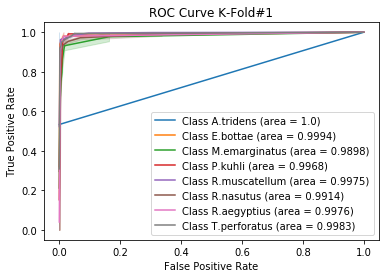

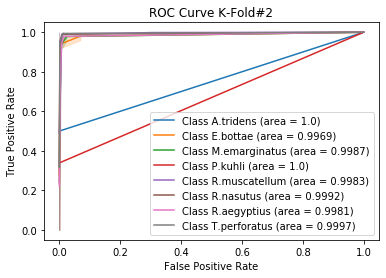

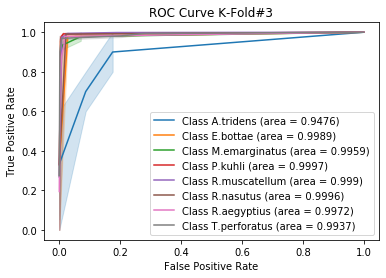

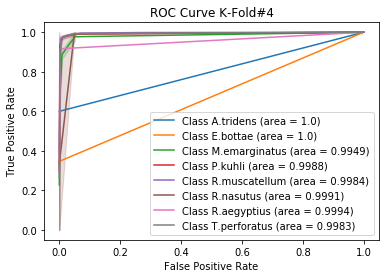

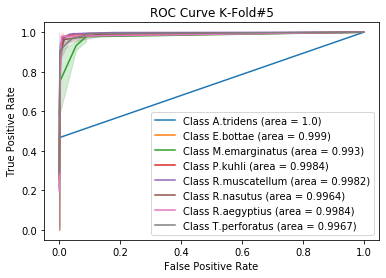

In [12]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  117    1    0    4    1    1    0]
 [   0    0   94    1   11    0    4    2]
 [   0    2    1  286    5    3    1    1]
 [   0    2    6    2 1638    0   11    6]
 [   0    6    1    7    3  251    1    0]
 [   0    0    2    1    1    0  117    0]
 [   0    0    3    0   17    0    6  377]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  23   0   0   0   0   0   0]
 [  0   0  18   0   2   0   0   0]
 [  0   0   0  57   1   0   0   0]
 [  0   0   1   0 327   0   2   1]
 [  0   1   0   1   0  50   0   0]
 [  0   0   0   0   0   0  23   0]
 [  0   0   0   0   3   0   1  75]]


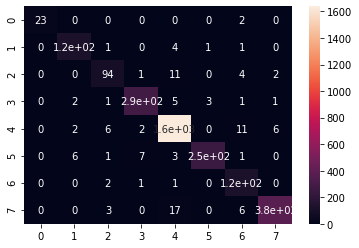

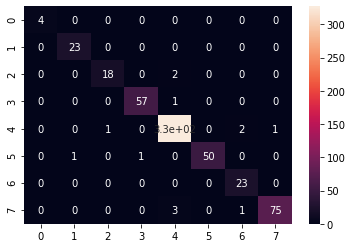

In [13]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt


## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.94 0.01 0.   0.03 0.01 0.01 0.  ]
 [0.   0.   0.84 0.01 0.1  0.   0.04 0.02]
 [0.   0.01 0.   0.96 0.02 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.01 0.  ]
 [0.   0.02 0.   0.03 0.01 0.93 0.   0.  ]
 [0.   0.   0.02 0.01 0.01 0.   0.97 0.  ]
 [0.   0.   0.01 0.   0.04 0.   0.01 0.94]]


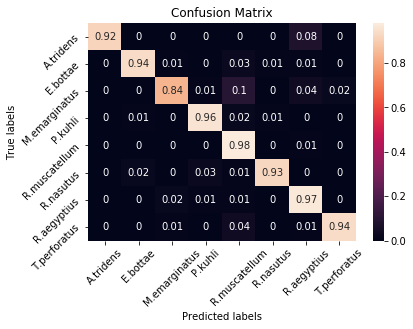

In [14]:
cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);